In [5]:
import csv
import numpy as np
import math
import matplotlib.pyplot as plt
import string
import random
import scipy

from data import utils
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
%matplotlib inline

from sklearn import linear_model
from sklearn.metrics import accuracy_score

alphabet = string.ascii_lowercase + '#' + '.'
D = len(alphabet)

def read_csv(filepath):
    pres, past = [], []
    with open(filepath, "rb") as csvfile:
        reader = csv.reader(csvfile, delimiter=",")
        for row in reader:
            pres.append(row[0])
            past.append(row[1])
            
    return pres, past

def ngram_encode(ngram_str, letter_vecs, window=3):
    vec = np.zeros(letter_vecs.shape[1])
    full_str = '#' + ngram_str + '.'
    for il, l in enumerate(full_str[:-(window-1)]):
        trivec = letter_vecs[alphabet.find(full_str[il]), :]
        for c3 in range(1, window):
            trivec = trivec * np.roll(letter_vecs[alphabet.find(full_str[il+c3]), :], c3)
            
        vec += trivec
    return vec

def ngram_encode_cl(ngram_str, letter_vecs, window=3):
    vec = np.zeros(letter_vecs.shape[1])
    full_str = '#' + ngram_str + '.' 
    for il, l in enumerate(full_str[:-(window-1)]):
        trivec = letter_vecs[alphabet.find(full_str[il]), :]
        for c3 in range(1, window):
            trivec = trivec * np.roll(letter_vecs[alphabet.find(full_str[il+c3]), :], c3)
        vec += trivec
    return 2* (vec + 0.1*(np.random.rand(letter_vecs.shape[1])-0.5) < 0) - 1

# encoding the past (by precedent lmao). unidirectional
# letters1_past x (letters2_pres - letters2_past) + letters1_past
def ngram_encode1(past, pres, past_letters, pres_letters, window=3):
    past_enc = ngram_encode_cl(past, past_letters, window)
    pres_enc = ngram_encode_cl(pres, pres_letters, window)
    vec = past_enc * (pres_enc - past_enc) + past_enc
    return vec
    
def ngram_encode1_cl(past, pres, past_letters, pres_letters, window=3):
    past_enc = ngram_encode_cl(past, past_letters, window)
    pres_enc = ngram_encode_cl(pres, pres_letters, window)
    vec = past_enc * (pres_enc - past_enc) + past_enc
    return 2* (vec + 0.1*(np.random.rand(past_letters.shape[1])-0.5) < 0) - 1
    
def encodes(words, past_tense, window=3):
    seen = []
    for i in range(len(words)):
        enc = ngram_encode_cl(words[i], RI_pres, window)
        enc_past = ngram_encode_cl(past_tense[i], RI_past, window)
        seen.append((enc, enc_past))
    return seen

def encodes1(words, past_tense, window=3):
    seen = []
    for i in range(len(words)):
        enc = ngram_encode1_cl(words[i], past_tense[i], RI_pres, RI_past, window)
        enc_past = ngram_encode1_cl(past_tense[i], words[i], RI_past, RI_pres, window)
        seen.append((enc, enc_past))
    return seen

def map_train(encoded, epochs=1):
    total_vec = np.zeros(N) #psi
    for e in range(epochs):
        for i in range(len(encoded)):
            total_vec += np.multiply(encoded[i][0], encoded[i][1])
    return total_vec

def perceptron_map_train(encoded, epochs=1):
    total_vec = np.zeros(N) #psi
    for e in range(epochs):
        for i in range(len(encoded)):
            # if predict correctly, add to total_vec with a smaller weight
            train_pred, random_pred = sim(total_vec, [encoded[i]])
            if train_pred > random_pred:
                total_vec += ((N-train_pred)/float(N)) * np.multiply(encoded[i][0], encoded[i][1])
            else:
                total_vec += np.multiply(encoded[i][0], encoded[i][1])
    return total_vec

def sim(model, encoded):
    data1, data3 = np.zeros(len(encoded)), np.zeros(len(encoded))
    total1, total3, count = 0, 0, 0
    
    random_vecs = np.random.randn(len(encoded), N)
    
    for j in range(len(encoded)):
        pair = encoded[j]
        sim1 = np.dot(np.multiply(model, pair[0]), pair[1])
        total1 += sim1

        sim3 = np.dot(np.multiply(model, random_vecs[j,:]), pair[0])
        total3 += sim3

        count += 1
        data1[j] = sim1 #total1/float(count)
        data3[j] = sim3 #total3/float(count)

    return data1, data3


def graph(train_func, epochs, encoded, test_encoded, title):
    test_m = np.arange(1, len(encoded), 1)

    train_dot = np.zeros_like(test_m)
    test_dot = np.zeros_like(test_m) # np.zeros(test_m.shape)
    random_dot = np.zeros_like(test_m)

    for im, m in enumerate(test_m):
        map_model = train_func(encoded[:int(m)], epochs)
        d1, d3 = sim(map_model, encoded[:int(m)])
        d2, d4 = sim(map_model, test_encoded)
        train_dot[im] = d1.mean()
        test_dot[im] = d2.mean()
        random_dot[im] = d3.mean()

    fig = plt.figure()
    plt.plot(test_m, train_dot)
    plt.plot(test_m, random_dot)
    plt.plot(test_m, test_dot)
    fig.suptitle(title, fontsize=20)
    plt.xlabel('number of words', fontsize=18)
    plt.ylabel('average dot product', fontsize=16)
    plt.show()
    #fig.savefig('test.jpg')

In [7]:
# data/cleaned/irregular_verbs_clean.csv
# data/cleaned/regular_verbs_clean.csv
# past is encoded
train_ratio = 2/3.0
epochs = 1
regular_present, regular_past = read_csv("data/cleaned/regular_verbs_clean.csv")
regular_present, regular_past = utils.Shuffle(regular_present, regular_past)
regular_present, regular_past = list(regular_present), list(regular_past)
num_reg = len(regular_present)
irregular_present, irregular_past = read_csv("data/cleaned/irregular_verbs_clean.csv")
#irregular_present, irregular_past = read_csv("data/cleaned/irregular_verbs_final.csv")
irregular_present, irregular_past = utils.Shuffle(irregular_present, irregular_past)
irregular_present, irregular_past = list(irregular_present), list(irregular_past)
num_irreg = len(irregular_present)
joint_present = regular_present + irregular_present
joint_past = regular_past + irregular_past
joint_present, joint_past = utils.Shuffle(joint_present, joint_past)
joint_present, joint_past = list(joint_present), list(joint_past)
num_joint = len(joint_present)

reg_pres_train = regular_present[:int(num_reg*train_ratio)]
reg_pres_test = regular_present[int(num_reg*train_ratio):]
reg_past_train = regular_past[:int(num_reg*train_ratio)]
reg_past_test = regular_past[int(num_reg*train_ratio):]

irreg_pres_train = irregular_present[:int(num_irreg*train_ratio)]
irreg_pres_test = irregular_present[int(num_irreg*train_ratio):]
irreg_past_train = irregular_past[:int(num_irreg*train_ratio)]
irreg_past_test = irregular_past[int(num_irreg*train_ratio):]

joint_pres_train = joint_present[:int(num_joint*train_ratio)]
joint_pres_test = joint_present[int(num_joint*train_ratio):]
joint_past_train = joint_past[:int(num_joint*train_ratio)]
joint_past_test = joint_past[int(num_joint*train_ratio):]

N: 1000


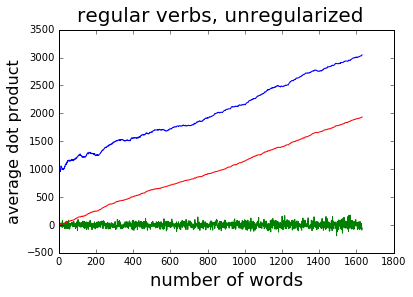

KeyboardInterrupt: 

In [8]:
N = 1000
while N < 1500:
    print "N: " + str(N)
    RI_pres = np.random.rand(D, N)
    RI_pres = np.where(RI_pres>0.5, 1, -1)

    RI_past = np.random.rand(D, N)
    RI_past = np.where(RI_past>0.5, 1, -1)

    
    reg_encoded = encodes(reg_pres_train, reg_past_train)
    reg_test_encoded = encodes(reg_pres_test, reg_past_test)

    
    irreg_encoded = encodes(irreg_pres_train, irreg_pres_train)
    irreg_test_encoded = encodes(irreg_pres_test, irreg_past_test)

    
    joint_encoded = encodes(joint_pres_train, joint_pres_train)
    joint_test_encoded = encodes(joint_pres_test, joint_past_test)

    # 1. regular verbs, unregularized
    graph(map_train, epochs, reg_encoded, reg_test_encoded, "regular verbs, unregularized")
    # 2. regular verbs, regularized
    graph(perceptron_map_train, epochs, reg_encoded, reg_test_encoded, "regular verbs, regularized")
    # 3. irregular verbs, unregularized
    graph(map_train, epochs, irreg_encoded, irreg_test_encoded, "irregular verbs, unregularized")
    # 4. irregular verbs, regularized
    graph(perceptron_map_train, epochs, irreg_encoded, irreg_test_encoded, "irregular verbs, regularized")
    # 5. regular and irregular verbs, unregularized
    graph(map_train, epochs, joint_encoded, joint_test_encoded, "joint verbs, unregularized")
    # 6. regular and irregular verbs, regularized
    graph(perceptron_map_train, epochs, joint_encoded, joint_test_encoded, "joint verbs, regularized")
    N += 500

N: 500


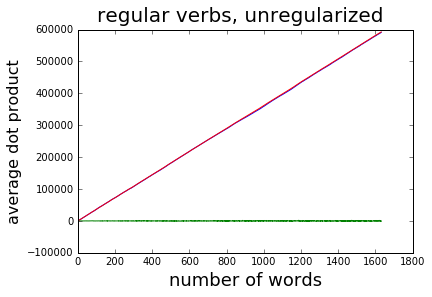

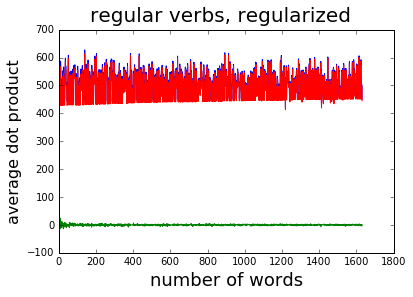

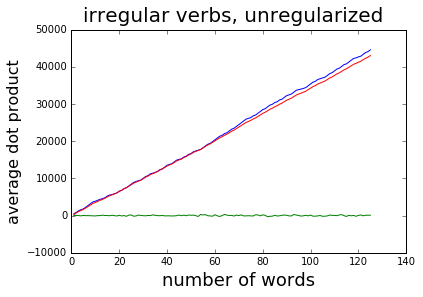

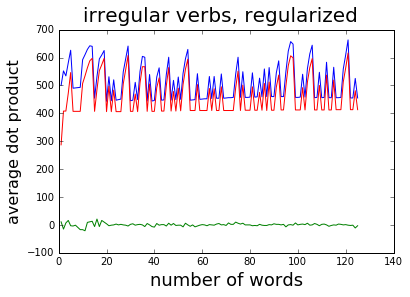

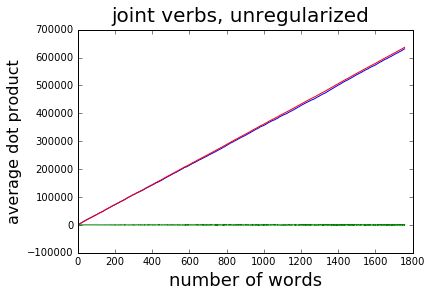

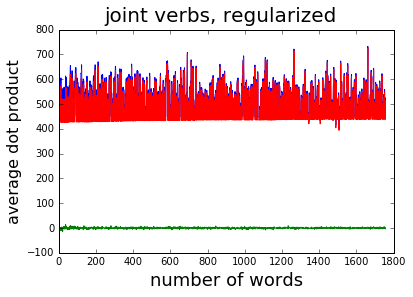

N: 1000


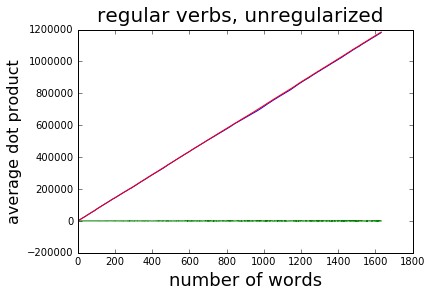

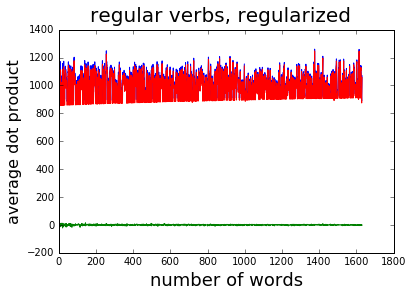

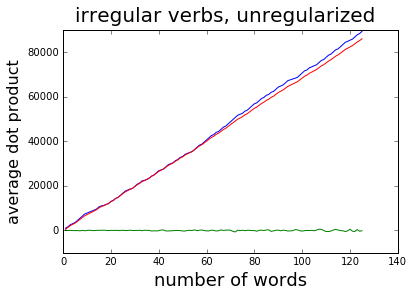

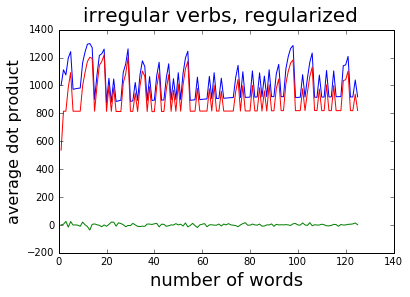

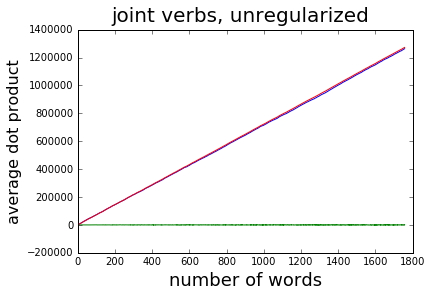

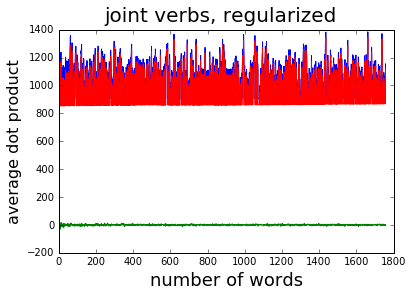

N: 1500


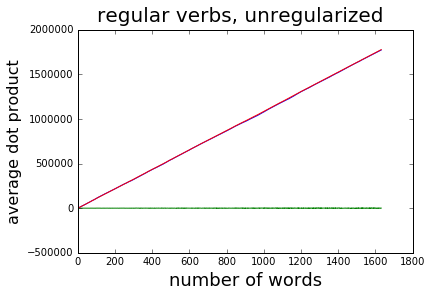

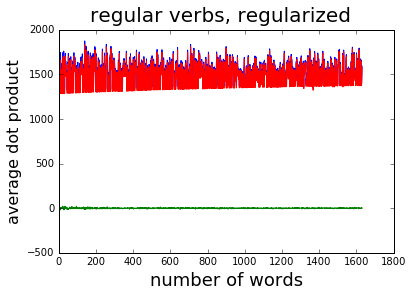

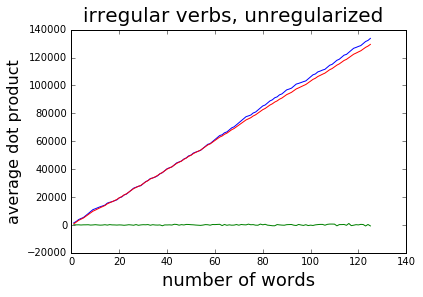

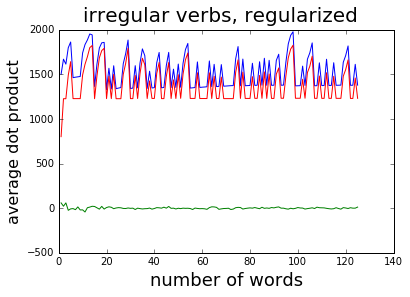

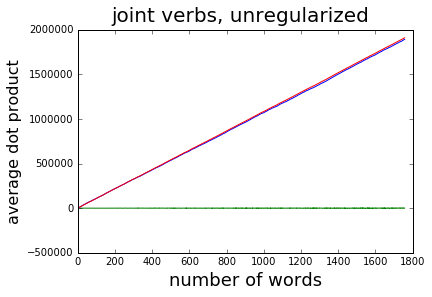

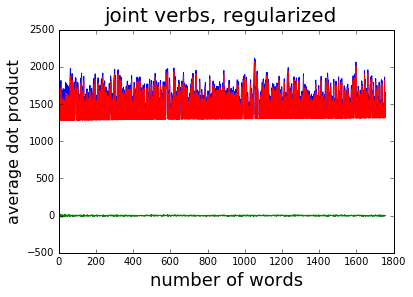

N: 2000


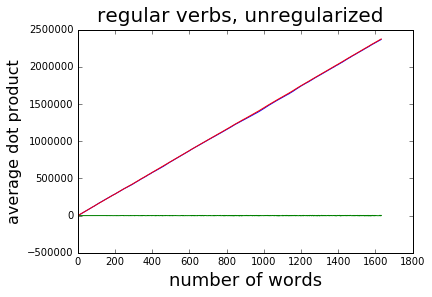

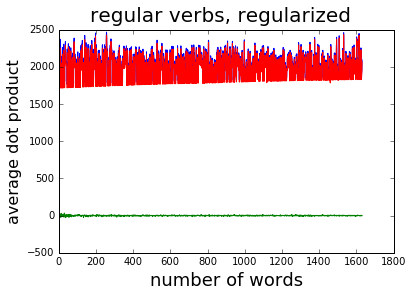

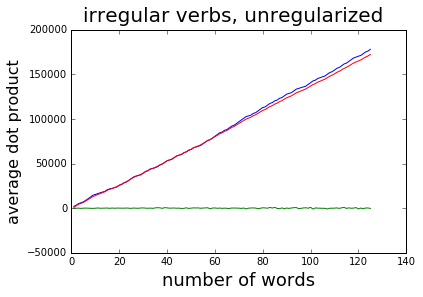

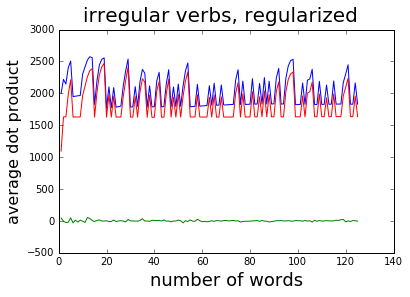

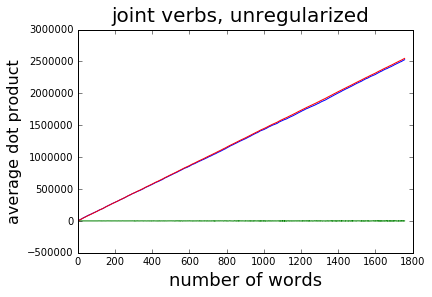

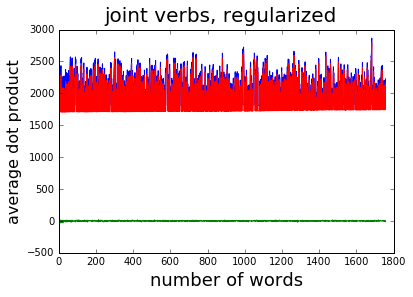

In [4]:
# alternative encoding
N = 1000
while N < 1500:
    print "N: " + str(N)
    RI_pres = np.random.rand(D, N)
    RI_pres = np.where(RI_pres>0.5, 1, -1)

    RI_past = np.random.rand(D, N)
    RI_past = np.where(RI_past>0.5, 1, -1)
    reg_encoded = encodes1(reg_pres_train, reg_past_train)
    reg_test_encoded = encodes1(reg_pres_test, reg_past_test)

    irreg_encoded = encodes1(irreg_pres_train, irreg_pres_train)
    irreg_test_encoded = encodes1(irreg_pres_test, irreg_past_test)

    joint_encoded = encodes1(joint_pres_train, joint_pres_train)
    joint_test_encoded = encodes1(joint_pres_test, joint_past_test)

    # 1. regular verbs, unregularized
    graph(map_train, epochs, reg_encoded, reg_test_encoded, "regular verbs, unregularized")
    # 2. regular verbs, regularized
    graph(perceptron_map_train, epochs, reg_encoded, reg_test_encoded, "regular verbs, regularized")
    # 3. irregular verbs, unregularized
    graph(map_train, epochs, irreg_encoded, irreg_test_encoded, "irregular verbs, unregularized")
    # 4. irregular verbs, regularized
    graph(perceptron_map_train, epochs, irreg_encoded, irreg_test_encoded, "irregular verbs, regularized")
    # 5. regular and irregular verbs, unregularized
    graph(map_train, epochs, joint_encoded, joint_test_encoded, "joint verbs, unregularized")
    # 6. regular and irregular verbs, regularized
    graph(perceptron_map_train, epochs, joint_encoded, joint_test_encoded, "joint verbs, regularized")
    N += 500

In [ ]:
# running more epochs decreases test accuracy for some reason